In [860]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import concatenate
from numpy import argmax
import tensorflow as tf
from tensorflow import keras
from numpy import dstack
import numpy as np
import matplotlib.pyplot as plt

In [861]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = './models/imageclassifier_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [862]:
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(64, activation='relu')(merge)
	output = Dense(1, activation='sigmoid')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
	return model

In [863]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	
	
	# encode output data
	# print(len(inputy))
	# print(inputX)
	# inputy_enc = to_categorical(inputy)
	# print(np.shape(inputy_enc))
	# fit model
	history = model.fit(X,inputy, epochs=10, verbose=0)
	return history

In [864]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

In [865]:
data = tf.keras.utils.image_dataset_from_directory('Images')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Found 202 files belonging to 2 classes.


In [866]:
n_members = 2
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
for model in members:
	_, acc = model.evaluate(test, verbose=0)
	print('Model Accuracy: %.3f' % acc)

>loaded ./models/imageclassifier_1.h5
>loaded ./models/imageclassifier_2.h5
Loaded 2 models
Model Accuracy: 0.562
Model Accuracy: 0.688


In [867]:
stacked_model = define_stacked_model(members)

In [868]:
# np.shape(trainy)
history = fit_stacked_model(stacked_model, list(train)[0][0], list(train)[0][1])
# fit_stacked_model(stacked_model, train)

In [869]:
yhat = predict_stacked_model(stacked_model, list(test)[0][0])

In [870]:
yhat = argmax(yhat, axis=1)
acc = accuracy_score(list(test)[0][1], yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.469


In [871]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

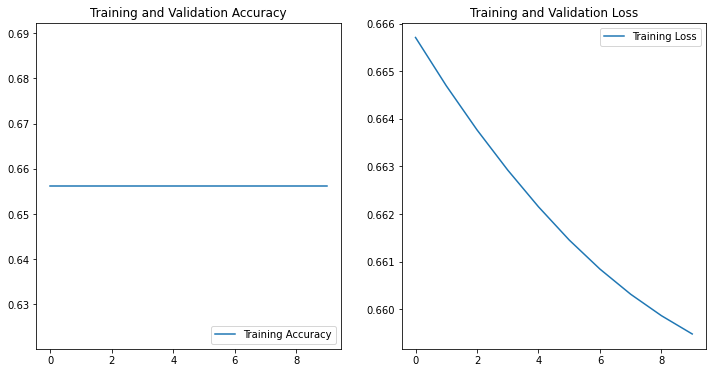

In [872]:
plot_history(history)